In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.nn import functional as F

import json
import re

import numpy as np

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !pip3 install pymorphy2[fast]
# !pip3 install gensim
# !pip3 install torchtext

In [3]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

def normal_form(word):
    return morph.parse(word)[0].normal_form

In [4]:
# import pandas as pd

# df = pd.read_csv('../data/lenta-ru-news.csv')
# with open('../data/lenta-texts.json', 'w') as f:
#     json.dump([{'text':i} for i in df.title], f)

In [5]:
# import random

# # with open('../data/lenta-texts.json', 'r') as f:
# #     q = json.load(f)
# # with open('../data/lenta-texts-small.json', 'w') as f:
# #     json.dump(q[-10000:], f)

# with open('../data/lenta-texts-small.json', 'r') as f:
#     q = json.load(f)
# random.shuffle(q)
# with open('../data/lenta-texts-small-val.json', 'w') as f:
#     json.dump(q[-100:], f)
# with open('../data/lenta-texts-small.json', 'w') as f:
#     json.dump(q[:-100], f)

# with open('../data/mem_big.json', 'r') as f:
#     q = json.load(f)
# print(len(q))
# random.shuffle(q)
# with open('../data/mem-val.json', 'w') as f:
#     json.dump(q[-100:], f)
    
# with open('../data/mem-train.json', 'w') as f:
#     json.dump(q[:-100], f)


In [6]:
texts = []

for file in tqdm_notebook(['lenta-texts-small.json', 'navalny.json', 'ntv.json', 'portnyagin.json', 'tvrain.json']):
    with open('../data/' + file, 'r') as f:
        temp_file = json.load(f)
        for text in temp_file:
            texts.append({'text' : text['text']})
print(len(texts))

with open('../data/joined.json', 'w') as f:
    json.dump(texts, f)


21366


In [7]:
def preprocess(text):
    return ' '.join([normal_form(i) for i in re.findall(r'[А-я]+', text) if len(i) > 2])

In [8]:
import torchtext.vocab as vocab

vectors = vocab.Vectors('../data/ruwiki_20180420_100d.txt') # file created by gensim


In [9]:
PAD_IDX = len(vectors.stoi) - 2
UNK_IDX = len(vectors.stoi) - 1
TOTAL_EMBS = len(vectors)

In [10]:
def vectorize(text):
    try:
        text = preprocess(text['text'])
    except TypeError as e:
        return None
    inds = []
    if len(text.split()) < 3:
        return None
    for word in text.split():
        try:
            inds.append(vectors.stoi[word])
        except KeyError:
            inds.append(UNK_IDX)
    if len(inds) < 2:
        return None
    while len(inds) < 90:
        inds.append(PAD_IDX)
    return inds[:90]

In [11]:
def vectorize_all(texts):
    ans = []
    for text in tqdm_notebook(texts):
        try:
            vec = vectorize(text)
        except Exception as e:
            continue
        if vec:
            ans.append(vec)
    return ans

In [12]:
class FasttextSet(Dataset):
    def __init__(self, cosmo, nocosmo):
        '''
        data - json file name
        '''
        with open(nocosmo, 'r') as f:
            self.nocosmo = json.load(f)
        self.nocosmo = np.array(vectorize_all(self.nocosmo))

        with open(cosmo, 'r') as f:
            self.cosmo = json.load(f)
        self.cosmo = np.array(vectorize_all(self.cosmo))
        
        
        self.x = np.row_stack([self.cosmo, self.nocosmo])
        self.y = np.concatenate([np.ones(len(self.cosmo)), np.zeros(len(self.nocosmo))])
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, ind):
        return torch.Tensor(self.x[ind]).long(), self.y[ind]

In [13]:
memLoader = DataLoader(FasttextSet('../data/mem-train.json', '../data/joined.json'),
                       batch_size=32, shuffle=True)

In [14]:
memLoader_val = DataLoader(FasttextSet('../data/mem-val.json', '../data/lenta-texts-small-val.json'),
                           batch_size=32, shuffle=True)

In [15]:
weights = torch.Tensor([len(memLoader.dataset.cosmo), len(memLoader.dataset.nocosmo)])
weights = weights/weights.sum()
weights = weights[0].cuda()

In [16]:
weights

tensor(0.3101, device='cuda:0')

In [17]:
class SimilarityNet(nn.Module):
    def __init__(self, ):
        super(SimilarityNet, self).__init__()
        self.embs = nn.Embedding(len(vectors), embedding_dim=100, padding_idx=PAD_IDX).from_pretrained(
            torch.FloatTensor(vectors.vectors)
        )
        self.process = nn.Sequential(
            nn.Conv1d(100, 128, 15),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.05),
            nn.Conv1d(128, 64, 9),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.05),
            nn.Conv1d(64, 32, 5),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.05),
            nn.Conv1d(32, 32, 5),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.05),
        )
        self.fc = nn.Sequential(
            nn.Linear(32, 1),
#             nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.process(self.embs(x).permute(0, 2, 1))
        x = torch.mean(x, dim=-1)
        return self.fc(x)

In [18]:
simnet = SimilarityNet().cuda()
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optim = torch.optim.Adam(simnet.parameters())

In [19]:
train_losses = []

for epoch in tqdm_notebook(range(100)):
    for x, target in tqdm_notebook(memLoader, leave=False):
        x, target = x.cuda(), target.cuda()
        optim.zero_grad()
        pred = simnet(x)
        loss = criterion(pred, target.unsqueeze(1).float())
        train_losses.append(loss.item())
        loss.backward()
        optim.step()


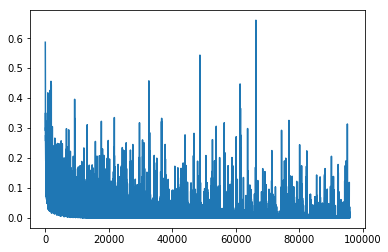

In [30]:
plt.plot(train_losses)

In [21]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


y_true = []
y_pred = []

for x, target in tqdm_notebook(memLoader_val):
    pred = simnet(x.cuda())
    for i, j in zip(pred.cpu().squeeze().detach().numpy(), target.detach().numpy()):
        y_pred.append(sigmoid(i))
        y_true.append(j)
        

In [22]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9954736842105263

In [23]:
with open('../data/mem-val.json', 'r') as f:
    c = json.load(f)
with open('../data/lenta-texts-small-val.json', 'r') as f:
    l = json.load(f)
    

In [24]:
def test_strs(x):
    x = vectorize(x)
    if not x:
        return None
    x = torch.Tensor(x).long().unsqueeze(0)
    ans = sigmoid(simnet(x.cuda()).item())
    return ans

In [25]:
for text in c:
    ans = test_strs(text)
    if ans:
        if ans > 0.15:
            print(text, '{0:.3f} '.format(ans))


{'text': 'Не ищи опору снаружи, она внутри тебя! Прочти наш гороскоп и отправляйся покорять этот день! 💫\n@cosmo_pisces – РЫБЫ ♓\u2028@cosmo_taurus – ТЕЛЕЦ ♉\u2028@cosmo_aquarius – ВОДОЛЕЙ ♒\u2028@cosmo_sagittarius – СТРЕЛЕЦ ♐\u2028@cosmo_scorpio – СКОРПИОН ♏\u2028@cosmo_libra – ВЕСЫ♎\u2028@cosmo_leo – ЛЕВ ♌\u2028@cosmo_aries – ОВЕН ♈\u2028@cosmo_cancer – РАК ♋\u2028@cosmo__capricorn – КОЗЕРОГ ♑\u2028@cosmo_virgo – ДЕВА ♍\u2028@cosmo_gemini – БЛИЗНЕЦЫ ♊ 📷@angela_nikolau'} 1.000 
{'text': 'Доброе утро! 🌊\nНе забудь сегодня покорить новые вершины. А как это сделать, читай в нашем самом точном прогнозе для всех знаков Зодиака и узнаешь, что тебя ждёт😉\n@cosmo_pisces – РЫБЫ ♓\n@cosmo_taurus – ТЕЛЕЦ ♉\n@cosmo_aquarius – ВОДОЛЕЙ ♒\n@cosmo_sagittarius – СТРЕЛЕЦ ♐\n@cosmo_scorpio – СКОРПИОН ♏\n@cosmo_libra – ВЕСЫ♎\n@cosmo_leo – ЛЕВ ♌\n@cosmo_aries – ОВЕН ♈\n@cosmo_cancer – РАК ♋\n@cosmo__capricorn – КОЗЕРОГ ♑\n@cosmo_virgo – ДЕВА ♍\n@cosmo_gemini – БЛИЗНЕЦЫ ♊'} 0.945 
{'text': 'Последняя рабоч

In [31]:
for text in l:
    ans = test_strs(text)
    if ans:
        print(text, '{0:.3f} '.format(ans))


RuntimeError: Expected object of backend CPU but got backend CUDA for argument #3 'index'

In [27]:
test_strs({'text':
           'Вот такие  🤔А вы что скажете? Черно по делу выступает гороскоп на Лобном или не всегда?'})

0.47729286064851567

In [28]:
1

1

In [29]:
simnet.cpu()
torch.save(simnet.state_dict(), '../models/simnet.state_dict')

In [1]:
%load_ext autoreload
%autoreload 2

import similarity as sim

In [2]:
sim.process_similarity({'text':
                 'кто ходит в гости по утру тот поступает мудро'})

0.5104919095249556

In [3]:
sim.process_emoji({'text': 'кто ходит в гости по утру тот поступает мудро'})

[[292 397 216]]


['😂', '🏻', '❤']